In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg
import matplotlib.ticker as ticker

import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
from scipy.stats import median_abs_deviation, wilcoxon, ttest_rel, pearsonr, spearmanr

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})
sns.set_style("white")

/scratch/local/ipykernel_830/2545171923.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


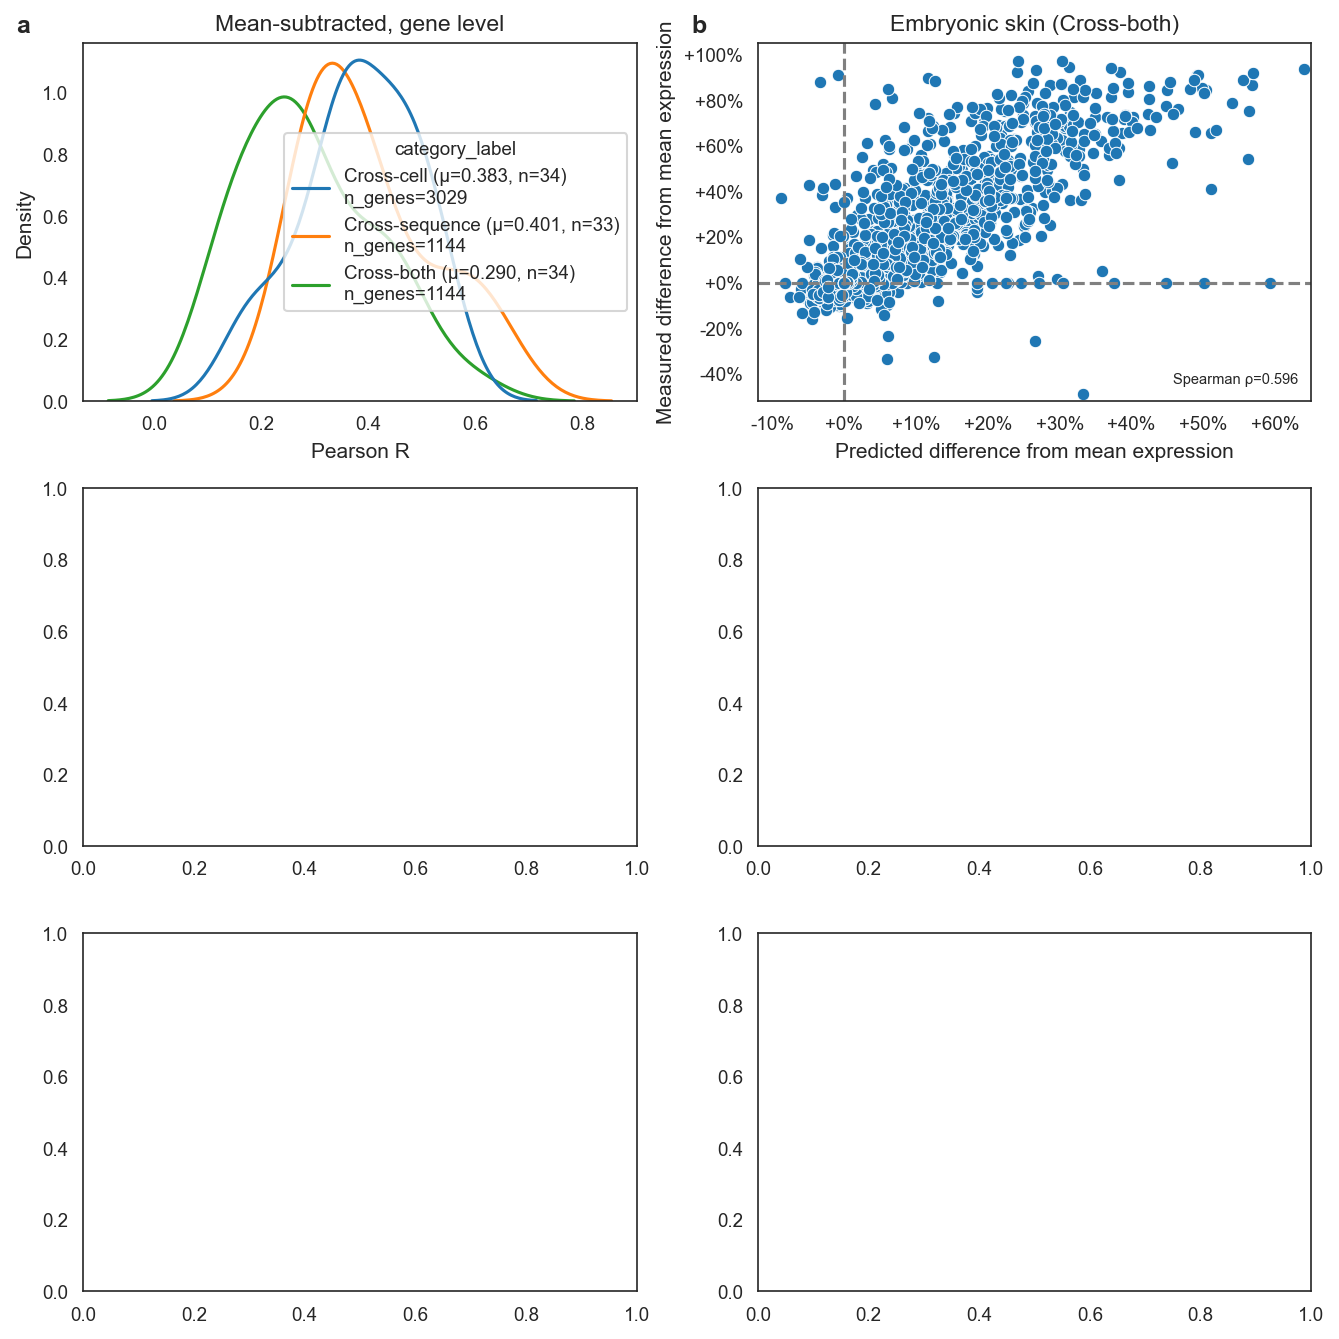

In [63]:
def create_figure5(
    cross_cell='/project/deeprna_data/benchmark/gene_level_cross_celltype/correlations_coding_genes.csv',
    cross_sequence='/project/deeprna_data/benchmark/gene_level_cross_region/correlations_coding_genes.csv',
    cross_both='/project/deeprna_data/benchmark/gene_level_cross_both_2/correlations_coding_genes.csv',
    n_genes_list = {'Cross-cell':3029, 'Cross-sequence':1144, 'Cross-both':1144},
    metric_col='mean-subtracted-pearson',
    b_sample_id = 24, b_sample_name = 'Embryonic skin tissue',
    b_predictions_path = '/project/deeprna_data/benchmark/gene_level_cross_both_2/all_expressions_grt.csv',
    b_true_path = '/project/deeprna_data/benchmark/gene_level_cross_both_2/all_expressions_encode.csv',
    figsize=(9,9),
    dpi=150,
    output_pdf='/project/deeprna/figures/paper/figure5.pdf',
    output_png='/project/deeprna/figures/paper/figure5.png'
):
    fig, axes = plt.subplots(3,2, figsize=figsize, dpi=dpi, constrained_layout=True)
    axs = axes.ravel()

    # A    
    axs[0].text(-0.12, 1.08, 'a', transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top')
    d1 = pd.read_csv(cross_cell)
    d1['category'] = 'Cross-cell'
    d2 = pd.read_csv(cross_sequence)
    d2['category'] = 'Cross-sequence'
    d3 = pd.read_csv(cross_both)
    d3['category'] = 'Cross-both'
    df = pd.concat([d1,d2,d3])

    # compute stats per category
    stats = {}
    categories = df['category'].unique()
    for cat in categories:
        sub = df[df['category'] == cat]
        # mean of metric (skip NaNs)
        mu = float(sub[metric_col].dropna().mean()) if len(sub[metric_col].dropna())>0 else float('nan')
        n_rows = int(len(sub))
        n_genes = n_genes_list[cat]
        stats[cat] = {'mu': mu, 'n_rows': n_rows, 'n_genes': n_genes}

    # Labels
    def _fmt_label(cat, s):
        mu = s['mu']
        nrows = s['n_rows']
        ng = s['n_genes']
        # format numbers: mu 3 decimals, n rows integer, n_genes integer or 'NA'
        ng_str = str(int(ng)) if (not pd.isna(ng)) else 'NA'
        return f"{cat} (μ={mu:.3f}, n={nrows})\nn_genes={ng_str}"
    df['category_label'] = df['category'].map(lambda c: _fmt_label(c, stats[c]))
    
    sns.kdeplot(df, x=metric_col, hue='category_label', ax=axs[0], common_norm=True)
    axs[0].set_xlabel('Pearson R')
    axs[0].set_title('Mean-subtracted, gene level')
    
    # B
    axs[1].text(-0.12, 1.08, 'b', transform=axs[1].transAxes, fontsize=12, fontweight='bold', va='top')
    pred = pd.read_csv(b_predictions_path, index_col=0)
    true = pd.read_csv(b_true_path, index_col=0)
    true_ms = true.sub(true.mean(axis=1), axis=0)
    pred_ms = pred.sub(pred.mean(axis=1), axis=0)
    true_ms_scaled = true_ms.values / (true.values + 0.001)
    pred_ms_scaled = pred_ms.values / (pred.values + 0.001)

    y=true_ms_scaled[:,b_sample_id]
    x=pred_ms_scaled[:,b_sample_id]
    
    sns.scatterplot(y=y, x=x, ax=axs[1])
    
    axs[1].set_xlabel('Predicted difference from mean expression')
    axs[1].set_ylabel('Measured difference from mean expression')
    axs[1].set_title('Embryonic skin (Cross-both)')
    axs[1].axhline(0, color='gray', linestyle='--')
    axs[1].axvline(0, color='gray', linestyle='--')
    axs[1].set_xlim(-0.12, 0.65)
    axs[1].set_ylim(-0.52, 1.05)
    
    # Formatter function
    def format_func(value, tick_number):
        if value >= 0:
            return f'+{value*100:.0f}%'
        else:
            return f'{value*100:.0f}%'
    # Apply formatter to x-axis
    axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    axs[1].text(0.75, 0.05, f'Spearman ρ={spearmanr(x,y)[0]:.3f}', transform=axs[1].transAxes, fontsize=7)

    plt.tight_layout()
    plt.savefig(output_pdf, dpi=dpi)
    plt.savefig(output_png, dpi=dpi)
    
create_figure5()